In [27]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
from xlrd.biffh import BIFF_FIRST_UNICODE
import xlwt
from scipy.stats import norm
from cycler import cycler
import seaborn as sns
import dynamic_stock_model as dsm

In [28]:
# Loading data
path = os.getcwd()
data = pd.read_csv(path+"/old_model/dummy_data_battery.csv", header=0 , sep=',')
# This is just to replace all the void values in "data" by 0, which makes things easier
data.fillna(0, inplace=True)

# We store the time and inflows values in two lists
time = data['Time'].tolist()
stock_cars = data['Population'].tolist() # FIXME: Is he stock just labeled wrongly as population or is it intended this way?


## Case 1
Cars have a lifetime that includes all types of failures, battery EoL being one of them. No battery replacement. 1 car = one battery, Outflow battery = outflow car 

Since this case includes all possible failures, the choice of lifetime should not be limted to the technical lifetime of the vehicle itself but should also consider how this might be affected by failures in the battery and vehicle crashes. Therefore, the probability that a failure occurs is greater than the techical lifetime of the vehicle itself and leads to a shorter choice of lifetime. 

This is a simpler and less explicit method for accounting for failures of both products with a single lifetime. 

In [90]:
stock_batteries_1_tc = np.zeros((years, years))
stock_cars_1_tc = np.zeros((years, years))
outflows_cars_1_tc = np.zeros((years, years))
outflows_batteries_1_tc = np.zeros((years, years))
stock_change_1 = [0] + np.diff(stock_cars).tolist()
outflows_cars_1 = [0]
outflows_batteries_1 = [0]
inflows_cars_1 = np.zeros(years)
inflows_battery_1 = [0]
stock_batteries_1 = [0]
# Definition of lifetime vector for cars 
lifetime_car = 16
st_dev_car = 4

years = len(time)

pdf_car = np.zeros(years)
for age in range(years):
    pdf_car[age] = norm(lifetime_car, st_dev_car).cdf(age) - norm(lifetime_car, st_dev_car).cdf(age - 1)
pdf_car = pdf_car/sum(pdf_car) # to ensure that the sum of the pdf function is 1 

 # Defining survival function
sf_cars = 1- np.cumsum(pdf_car)

# Calculating stock driven model
for t in range(years):
    for c in range(t):
        outflows_cars_1_tc[t,c]         = inflows_cars_1[c] * pdf_car[t-c]
        # the outflow of batteries from a cohort is equal to the outflows of the vehicles
        outflows_batteries_1_tc[t,c]    = outflows_cars_1_tc[t,c]
        stock_cars_1_tc[t,c]            = inflows_cars_1[c] * sf_cars[t-c]
    inflows_cars_1[t]       = stock_change_1[t] + outflows_cars_1_tc.sum(axis=1)[t]
# Calculating aggregated values
outflows_cars_1         = outflows_cars_1_tc.sum(axis=1)
# Calculating the values for batteries
outflows_batteries_1    = outflows_batteries_1_tc.sum(axis=1)
inflows_battery_1       = inflows_cars_1
stock_batteries_1_tc    = stock_cars_1_tc

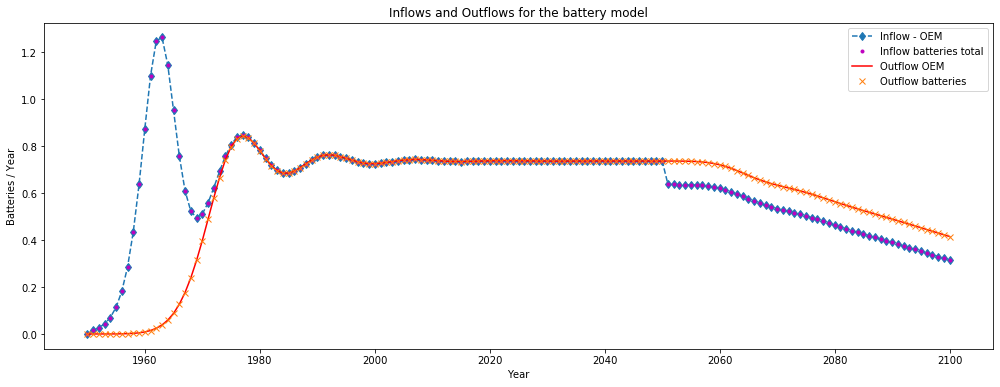

In [91]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_1, 'd--', label='Inflow - OEM')
plt.plot(time, inflows_battery_1, 'm.', label='Inflow batteries total')
plt.plot(time, outflows_cars_1,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_1,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 2
Cars have a lifetime that includes all types of failures, battery EoL being one of them. Still, it is assumed that some batteries will be replaced at a given rate. More than one battery in the lifetime of the car. Outflow battery >= outflow car

In this case the failure of batteries is accounted for by a replacement rate and therefore the lifetime of the vehicle can be assumed to not be affected to the same extent as in case 1. Limitations to this approach might be that the outflows and battery inflows are estimated at different times as the case where a separate lifetime would be calculated for the batteries. It is more suitable if the stock is approximately constant. 

In [97]:
stock_batteries_2_tc = np.zeros((years, years))
stock_cars_2_tc = np.zeros((years, years))
outflows_cars_2_tc = np.zeros((years, years))
outflows_batteries_2_tc = np.zeros((years, years))
stock_change_2 = [0] + np.diff(stock_cars).tolist()
outflows_cars_2 = [0]
outflows_batteries_2 = [0]
inflows_cars_2 = np.zeros(years)
inflows_battery_2 = np.zeros(years)
stock_batteries_1 = [0]
# Definition of lifetime vector for cars 
lifetime_car = 16
st_dev_car = 4

# Definition of replacement rate. Example for the case where 50% of the batteries are replaced
r = 0.5

years = len(time)

pdf_car = np.zeros(years)
for age in range(years):
    pdf_car[age] = norm(lifetime_car, st_dev_car).cdf(age) - norm(lifetime_car, st_dev_car).cdf(age - 1)
pdf_car = pdf_car/sum(pdf_car) # to ensure that the sum of the pdf function is 1 

 # Defining survival function
sf_cars = 1- np.cumsum(pdf_car)

# Calculating stock driven model
for t in range(years):
    for c in range(t):
        outflows_cars_2_tc[t,c]         = inflows_cars_2[c] * pdf_car[t-c]
        # the outflow of batteries from a cohort is equal to the outflows of the vehicles times a replacement rate
        outflows_batteries_2_tc[t,c]    = outflows_cars_2_tc[t,c] * (1+r) 
        stock_cars_2_tc[t,c]            = inflows_cars_2[c] * sf_cars[t-c]
    inflows_cars_2[t]           = stock_change_2[t] + outflows_cars_2_tc.sum(axis=1)[t]
    inflows_battery_2[t]        = stock_change_2[t] + outflows_batteries_2_tc.sum(axis=1)[t]
# Calculating aggregated values
outflows_cars_2         = outflows_cars_2_tc.sum(axis=1)
# Calculating the values for batteries
outflows_batteries_2    = outflows_batteries_2_tc.sum(axis=1)
stock_batteries_2_tc    = stock_cars_2_tc # FIXME: In this case, since we use a replacement rate, we cannot say what is the cohort composition of the battery stock. 

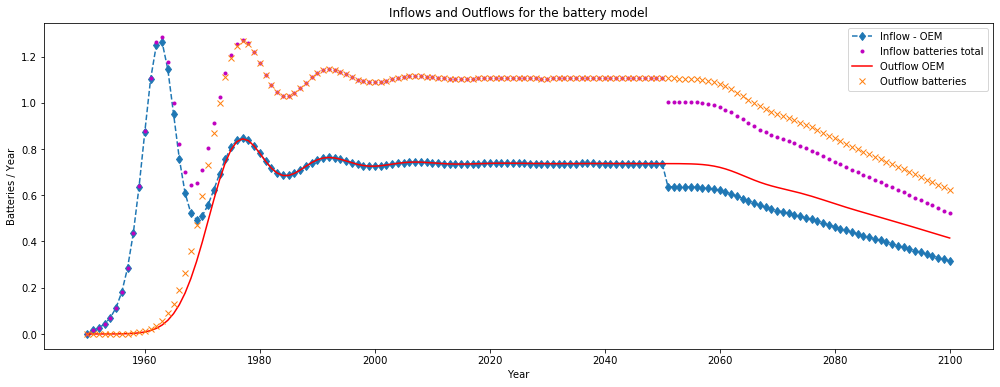

In [98]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_2, 'd--', label='Inflow - OEM')
plt.plot(time, inflows_battery_2, 'm.', label='Inflow batteries total')
plt.plot(time, outflows_cars_2,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_2,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 3

Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries can neither be replaced nor reused, meaning that if either the car or the battery fail, they are both scrapped.

In this case, the combined lifetimes of the battery and the car yield a smaller effective lifetime that dictates the outflows based on all failures. This would be a similar case as 1, but the effective lifetime choice is more explicit and potentially more robust, since it considers aspects of both products. 

Since now we have two pdf curves causing the outflows, the commulative probability of the pdf curve is greater than 1. Therefore, we need to aggregate the two lifetimes and create a combined one. 

A different battery lifetime is chosen here to better illustrate the case. 

In [246]:
stock_batteries_3_tc = np.zeros((years, years))
stock_cars_3_tc = np.zeros((years, years))
outflows_cars_3_tc = np.zeros((years, years))
outflows_batteries_3_tc = np.zeros((years, years))
stock_change_3 = [0] + np.diff(stock_cars).tolist()
outflows_cars_3 = [0]
outflows_batteries_3 = [0]
inflows_cars_3 = np.zeros(years)
inflows_battery_3 = np.zeros(years)
stock_batteries_3 = [0]
# Definition of lifetime vector for cars 
lifetime_car_3 = 16
st_dev_car_3= 4

lifetime_battery_3 = 10
st_dev_battery_3 = 3 

years = len(time)

pdf_car_3 = np.zeros(years)
for age in range(years):
    pdf_car_3[age] = norm(lifetime_car_3 , st_dev_car_3).cdf(age) - norm(lifetime_car_3, st_dev_car_3).cdf(age - 1)
pdf_car_3 = pdf_car_3/sum(pdf_car_3) # to ensure that the sum of the pdf function is 1 

pdf_battery_3 = np.zeros(years)
for age in range(years):
    pdf_battery_3[age] = norm(lifetime_battery_3, st_dev_battery_3).cdf(age) - norm(lifetime_battery_3, st_dev_battery_3).cdf(age - 1)
pdf_battery_3 = pdf_battery_3/sum(pdf_battery_3)  # to ensure that the sum of the pdf function is 1
 # Defining survival functions
sf_cars_3 = 1- np.cumsum(pdf_car_3)
sf_battery_3 = 1- np.cumsum(pdf_battery_3)

sf_cars_tc = np.zeros((years, years))
for t in range(years):
    for c in range(t):
        sf_cars_tc[t,c] = sf_cars_3[t-c]

sf_battery_tc = np.zeros((years, years))
for t in range(years):
    for c in range(t):
        sf_battery_tc[t,c] = sf_battery_3[t-c]

# Calculating stock driven model
for t in range(years): 
    stock_cars_3_tc[t,t]= inflows_cars_3[t]
    for c in range(t): 
        if sf_battery_tc[t-1,c] != 0: 
        # the outflow of batteries from a cohort is equal to the outflows of the vehicles
            outflows_batteries_3_tc[t,c]    = stock_cars_3_tc[t-1,c]/sf_battery_tc[t-1,c]*pdf_battery_3[t-c]
            #print(outflows_batteries_3_tc[t-1,c])
            outflows_cars_3_tc[t,c]         = (stock_cars_3_tc[t-1,c] - outflows_batteries_3_tc[t,c]) / sf_cars_tc[t-1,c] * pdf_car[t-c]
            stock_cars_3_tc[t,c]            = stock_cars_3_tc[t-1,c] - outflows_batteries_3_tc[t,c] - outflows_cars_3_tc[t,c]
        else:
            outflows_batteries_3_tc[t,c] = 0
            outflows_cars_3_tc[t,c] = 0
    inflows_cars_3[t] = stock_change_3[t] + outflows_cars_3_tc.sum(axis=1)[t]
    inflows_battery_3[t] = stock_change_3[t] + outflows_batteries_3_tc.sum(axis=1)[t]
# Calculating aggregated values
outflows_cars_3 = outflows_cars_3_tc.sum(axis=1)
# Calculating the values for batteries
outflows_batteries_3 = outflows_batteries_3_tc.sum(axis=1)
stock_batteries_3_tc = stock_cars_3_tc 

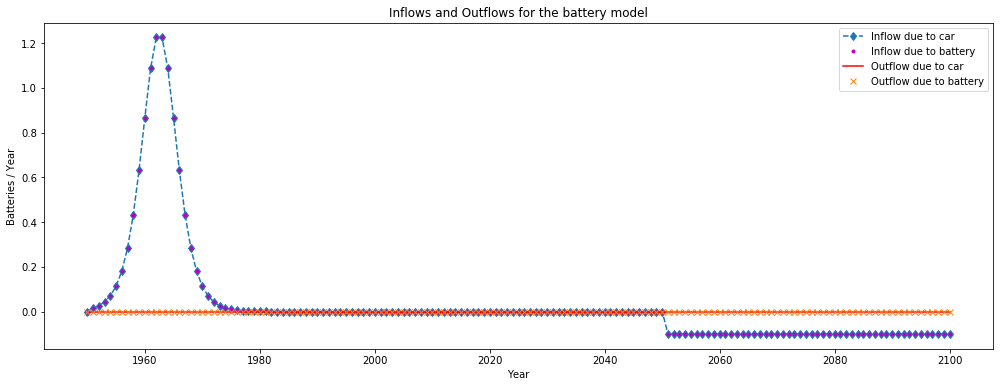

In [242]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_3 , 'd--', label='Inflow due to car')
plt.plot(time, inflows_battery_3, 'm.', label='Inflow due to battery')
plt.plot(time, outflows_cars_3,'r', label='Outflow due to car')
plt.plot(time, outflows_batteries_3,'x', label='Outflow due to battery')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 4 
Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries cannot be replaced, but they can be reused. If the battery fails, the car is scrapped. If the car fails but the status of the battery is still good, it can be reused in a new car (we call this reuse rate R in the table). This case does not necessarily make sense for cars, but could be useful for other applications.

We can also take the effective lifetime approach and define the batteries that are still reusable as the area between the effective lifetime above the battery pdf, which is equal to the vehicle outflows with funcitoning batteries. The vehicle outflows still depend on the effective lifetime, but the battery outflows are mitigated by the reuse. An added logic may be needed for defining how many batteries from the total should be reused, as some of them could fail very quickly after the reuse has taken place. 